# GEN ALL

*This notebook is intended to be used as a generator of adversarial examples using all five methods.*

## Structure

- Imports
- Global settings
  - Max norm, size of max-norm ball in which I seek for adversarial examples
    - 50 / 255
  - Model that is used
    - MnistCnnPatt
  - batch_size - number of benign examples
    - 10 for testing, 1000 for real application
- Functions that create adversarial examples given benign examples
  - In batch mode
- Generation mechanism and statistics capture
  - save generated adv. examples as images
  - percentage of success of attack

## Requirements

- Simple parallelization
  - meaning that computation can be split across several jupyter notebooks eventually

# 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

In [3]:
import torch.nn as nn
import torch

In [4]:
from utils import MnistData
from models import ModelManager, ModelType

In [5]:
import numpy as np
from matplotlib import pyplot as plt

# 1. Gloabal settings

In [6]:
max_norm = 50 / 255

In [7]:
model = ModelManager.get_trained(ModelType.MnistCnnPatt)

In [36]:
batch_size = 2

In [9]:
data = MnistData(True)

# 2. Functions for adv. examples

### 1. FGSM

In [10]:
def fgsm(benign_examples: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    benign_examples.requires_grad = True
    if benign_examples.grad:
        benign_examples.grad.zero_()
    loss = loss_fn(model(benign_examples), labels)
    loss.backward()
    adversarial_examples = benign_examples + max_norm * benign_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)
    return MnistData.clip_for_image(adversarial_examples)

### 2. I-FGSM

In [11]:
def ifgsm(benign_examples: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    adversarial_examples = benign_examples.detach()
    step_size = 1e-2
    for _ in range(math.floor(min(max_norm * 4 * 255, max_norm * 255 * 1.25))):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad:
            adversarial_examples.grad.zero_()
        loss_fn(model(adversarial_examples), labels).backward()
        adversarial_examples = MnistData.clip(
            benign_examples,
            adversarial_examples + step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1),
            max_norm
        )
    return adversarial_examples

### 3. PGD

In [12]:
def pgd(benign_examples: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    adversarial_examples = benign_examples.detach() + 2 * max_norm * (torch.rand((len(labels), 1, 28, 28)) - 0.5)
    step_size = 1e-2
    for _ in range(math.floor(min(max_norm * 4 * 255, max_norm * 255 * 1.25))):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad:
            adversarial_examples.grad.zero_()
        loss_fn(model(adversarial_examples), labels).backward()
        adversarial_examples = MnistData.clip(
            benign_examples,
            adversarial_examples + step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1),
            max_norm
        )
    return adversarial_examples

### 4. L-BFGS

In [47]:
def solve_for_targeted(benign_example, target_label, c_lambda) -> torch.Tensor:
    print(f'\t{target_label}, {c_lambda}')
    step_size = 1e-2
    benign_example = benign_example.unsqueeze(0)
    while len(benign_example.shape) > 4:
        benign_example = benign_example.squeeze(0)
    adv = torch.zeros(benign_example.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm_of_diff = lambda x, y: torch.max(torch.abs(x - y))
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = c_lambda * norm_of_diff(adv, benign_example) \
            + loss_fn(model(adv), torch.Tensor([target_label]).type(torch.long))
        loss.backward()
        new_adv = MnistData.clip(
            benign_example,
            (adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1)),
            max_norm
        )
        adv = new_adv
    if MnistData.get_prediction(model, adv.squeeze(0))[0] == target_label or c_lambda < 1e-2:
        return adv.squeeze(0)
    return None

def lbfgs(benign_examples:torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    adversarial_examples = []
    for i in range(len(benign_examples)):
        benign_example, label = benign_examples[i], labels[i]
        advs = []
        for i in [j for j in range(10) if j != label]:
            c_lambda = 500
            adv = None
            while adv is None:
                adv = solve_for_targeted(benign_example, i, c_lambda)
                c_lambda *= 0.7
            advs.append(adv)

        norm_of_diff = lambda x, y: torch.max(torch.abs(x - y))
        norms = []
        for adv in advs:
            norms.append(norm_of_diff(benign_example, adv))
        else:
            minout = min(norms)
            for i in range(len(advs)):
                if norms[i] == minout:
                    adversarial_examples.append(advs[i])
    return torch.Tensor([example.tolist() for example in adversarial_examples])

### 5. CW

In [51]:
def solve_for(benign_image, label, c_lambda):
    step_size = 1e-2
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm_of_diff = lambda x, y: torch.max(torch.abs(x - y))
    adv = adv.unsqueeze(0)
    benign_image = benign_image.unsqueeze(0)
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = norm_of_diff(adv, benign_image) \
            - c_lambda * loss_fn(model(adv), torch.Tensor([label]).type(torch.long))
        loss.backward()
        new_adv = MnistData.clip(
            benign_image,
            (adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1)),
            max_norm
        )
        adv = new_adv
    if MnistData.get_prediction(model, adv.squeeze(0))[0] != label or c_lambda > 500:
        return adv.squeeze(0)
    return None

def cw(benign_examples: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    advs = []
    for i in range(len(benign_examples)):
        benign_example, label = benign_examples[i], labels[i]
        adv = None
        c_lambda = 1e-1
        while adv is None:
            adv = solve_for(benign_example, label, c_lambda)
            c_lambda *= 1.3
        advs.append(adv)
    return torch.Tensor([adv.tolist() for adv in advs])

# 3. Generation mechanism

C:\Users\stani\AppData\Local\Temp/ipykernel_17828/877067200.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"AEXAMPLES\\ALLGEN\\benign_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
C:\Users\stani\AppData\Local\Temp/ipykernel_17828/877067200.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"AEXAMPLES\\ALLGEN\\fgsm_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
C:\Users\stani\AppData\Local\Temp/ipykernel_17828/877067200.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"AEXAMPLES\\ALLGEN\\ifgsm_{i}.png", bbox_inches="tight", pad_inches

fgsm: 2
ifgsm: 2
pgd: 2
lbfgs: 0
cw: 2


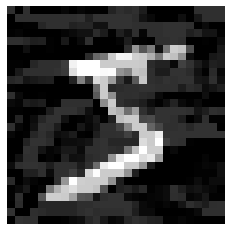

In [54]:
benign_examples, labels = data.draw_first(batch_size, model)

# Generation
fgsm_examples = fgsm(benign_examples, labels)
ifgsm_examples = ifgsm(benign_examples, labels)
pgd_examples = pgd(benign_examples, labels)
# lbfgs_examples = lbfgs(benign_examples, labels)
cw_examples = cw(benign_examples, labels)

# Save'em all
for i in range(batch_size):
    example = np.array(benign_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\benign_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
    
    example = np.array(fgsm_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\fgsm_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
    
    example = np.array(ifgsm_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\ifgsm_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
    
    example = np.array(pgd_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\pgd_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
    
    example = np.array(lbfgs_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\lbfgs_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
    
    example = np.array(cw_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\cw_{i}.png", bbox_inches="tight", pad_inches=0, pad_width=0)

fgsm_adversarials = MnistData.get_adversarials(model, benign_examples, labels, fgsm_examples)
print(f'fgsm: {len(fgsm_adversarials)}')

ifgsm_adversarials = MnistData.get_adversarials(model, benign_examples, labels, ifgsm_examples)
print(f'ifgsm: {len(ifgsm_adversarials)}')

pgd_adversarials = MnistData.get_adversarials(model, benign_examples, labels, pgd_examples)
print(f'pgd: {len(pgd_adversarials)}')

lbfgs_adversarials = MnistData.get_adversarials(model, benign_examples, labels, lbfgs_examples)
print(f'lbfgs: {len(lbfgs_adversarials)}')

cw_adversarials = MnistData.get_adversarials(model, benign_examples, labels, cw_examples)
print(f'cw: {len(cw_adversarials)}')    